## Clinical Text Classification for Medical Transcription 
We extracted lots of data with selected medical_specialty (feature) for classification based on domain knowledge, then performed Biomedical Text Processing (transcription) and t-SNE visualization, we also improved the classification by using SMOTE for imbalance data.

In [1]:
import pandas as pd
import numpy as np
import spacy 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

In [2]:
clinical_text_df = pd.read_csv('mtsamples.csv')
print(clinical_text_df.shape)
clinical_text_df.head(5)

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences = sent_tokenize(str(text).lower())
        sent_count += len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if (word in vocab.keys()):
                    vocab[word] = vocab[word] + 1
                else:
                    vocab[word] = 1
    word_count = len(vocab.keys())
    return sent_count, word_count

clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count, word_count = get_sentence_word_count(clinical_text_df['transcription'])
print('Nums of sentences are: ', sent_count)
print('Nums of words are: ', word_count)

Nums of sentences are:  140214
Nums of words are:  35805


In [4]:
# List all the categories of medical_specialty.
categories = set(clinical_text_df['medical_specialty'])
print(categories)
print(len(categories))

{' Pediatrics - Neonatal', ' Allergy / Immunology', ' Letters', ' Office Notes', ' Autopsy', ' Bariatrics', ' IME-QME-Work Comp etc.', ' Cardiovascular / Pulmonary', ' Surgery', ' Neurology', ' General Medicine', ' Speech - Language', ' Radiology', ' Orthopedic', ' Chiropractic', ' Rheumatology', ' Hematology - Oncology', ' Physical Medicine - Rehab', ' Gastroenterology', ' Obstetrics / Gynecology', ' Dentistry', ' Discharge Summary', ' Dermatology', ' Emergency Room Reports', ' Endocrinology', ' SOAP / Chart / Progress Notes', ' Lab Medicine - Pathology', ' Podiatry', ' Cosmetic / Plastic Surgery', ' Hospice - Palliative Care', ' Ophthalmology', ' Nephrology', ' ENT - Otolaryngology', ' Diets and Nutritions', ' Urology', ' Pain Management', ' Psychiatry / Psychology', ' Consult - History and Phy.', ' Sleep Medicine', ' Neurosurgery'}
40


## EDA

In [5]:
# We only choose the rows with certain lengths of records (medical_specialty).
data_categories = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 40)
new_data_categories = filtered_data_categories.groupby(clinical_text_df['medical_specialty'])
i = 1
for catName, dataCategory in new_data_categories:
    print(str(i) + ' ' + catName + ' : ' + str(len(dataCategory)))
    i += 1

1  Cardiovascular / Pulmonary : 371
2  Consult - History and Phy. : 516
3  Discharge Summary : 108
4  ENT - Otolaryngology : 96
5  Emergency Room Reports : 75
6  Gastroenterology : 224
7  General Medicine : 259
8  Hematology - Oncology : 90
9  Nephrology : 81
10  Neurology : 223
11  Neurosurgery : 94
12  Obstetrics / Gynecology : 155
13  Office Notes : 50
14  Ophthalmology : 83
15  Orthopedic : 355
16  Pain Management : 61
17  Pediatrics - Neonatal : 70
18  Podiatry : 47
19  Psychiatry / Psychology : 53
20  Radiology : 273
21  SOAP / Chart / Progress Notes : 166
22  Surgery : 1088
23  Urology : 156


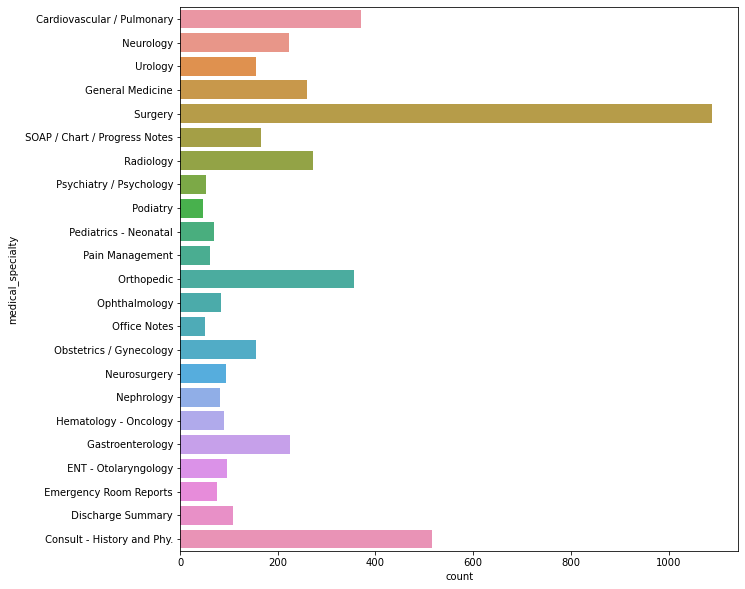

In [6]:
## Data visualization
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data=filtered_data_categories)
plt.show()

In [7]:
# Select two features (columns). 
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
print(data.shape)
display(data.head(2))

(4694, 2)


,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [8]:
print(data.iloc[14]['transcription'])

PROCEDURES:, Cystourethroscopy and transurethral resection of prostate.,COMPLICATIONS:, None.,ADMITTING DIAGNOSIS:, Difficulty voiding.,HISTORY:, This 67-year old Hispanic male patient was admitted because of enlarged prostate and symptoms of bladder neck obstruction.  Physical examination revealed normal heart and lungs.  Abdomen was negative for abnormal findings.  ,LABORATORY DATA:, BUN 19 and creatinine 1.1.  Blood group was A, Rh positive, Hemoglobin 13, Hematocrit 32.1, Prothrombin time 12.6 seconds, PTT 37.1.  Discharge  hemoglobin 11.4, and hematocrit 33.3.  Chest x-ray calcified old granulomatous disease, otherwise normal.  EKG was normal.  ,COURSE IN THE HOSPITAL:, The patient had a cysto and TUR of the prostate.  Postoperative course was uncomplicated. The pathology report is pending at the time of dictation.  He is being discharged in satisfactory condition with a good urinary stream, minimal hematuria, and on Bactrim DS one a day for ten days with a standard postprostatic 

## Data Cleaning and Extraction.

In [11]:
data.medical_specialty.unique()

array([' Cardiovascular / Pulmonary', ' Neurology', ' Urology',
       ' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes',
       ' Radiology', ' Psychiatry / Psychology', ' Podiatry',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Consult - History and Phy.'], dtype=object)

In [12]:
## We carefully select several features to avoid key words overlapping.
## deleted: [' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes', ' Pain Management', ' Nephrology', ' Emergency Room Reports', ' Discharge Summary', ' Consult - History and Phy.']
filter_categories_columns = [' Cardiovascular / Pulmonary',' Neurology', ' Urology', ' Radiology', ' Psychiatry / Psychology', 
                             ' Pediatrics - Neonatal', ' Orthopedic', ' Ophthalmology', ' Obstetrics / Gynecology', 
                             ' Hematology - Oncology', ' Gastroenterology', ' ENT - Otolaryngology', 'Podiatry']
filtered_data = data.loc[data['medical_specialty'].isin(filter_categories_columns)]
filtered_data = filtered_data.drop(filtered_data[filtered_data['transcription'].isna()].index)
filtered_data.shape

(2149, 2)

## Biomedical Text Processing and Vectorization

In [13]:
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
import spacy
import scispacy
import en_ner_bionlp13cg_md
nlp = spacy.load("en_ner_bionlp13cg_md")

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    replace_space = re.compile('[/(){}\[\]\@,;]')    
    text2 = text1.lower()
    text2 = replace_space.sub('', text2)
    return text2 

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)    
    intial_sentences = sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)

def process_Text(text):
    wordlist=[]
    doc=nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

filtered_data['transcription'] = filtered_data['transcription'].apply(clean_text).apply(lemmatize_text).apply(process_Text)
print(filtered_data.iloc[1]['transcription'])

left ventricular wall wall left ventricular left ventricular outflow tract left ventricular atrium atrium ventricle aortic root aortic valve aortic valve aortic valve mitral annular leaflet mitral valve mitral tricuspid valve pulmonary artery pulmonary artery pulmonary valve pulmonary pericardial intracardiac foramen interatrial septum


In [14]:
## Convert to vectors
vectorizer = TfidfVectorizer(analyzer='word', stop_words = 'english', ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat = vectorizer.fit_transform(filtered_data['transcription'].tolist())
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abdomen', 'abdomen abdomen', 'abdomen bowel', 'abdomen patient', 'abdomen pelvis', 'abdominal', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adipose', 'adnexal', 'adrenal', 'adrenal gland', 'air', 'air cell', 'airway', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allergiessocial', 'allis', 'allograft', 'amniotic', 'amniotic fluid', 'amoxicillin', 'ana', 'anal', 'andor', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'antebrachial', 'anterior', 'anterior abdominal', 'anterior abdominal wall', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior cruciate ligament', 'anterior lip', 'anterior posterior', 'anterior wall', 'anteriorly', 'anterolateral', 'antrum', 'aorta', 'aorta aorta', 'aortic', 'aortic arch', 'aortic valve', 'apical', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery artery', 'artery carotid', 'artery carotid artery'

C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## t-SNE Visualization

C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


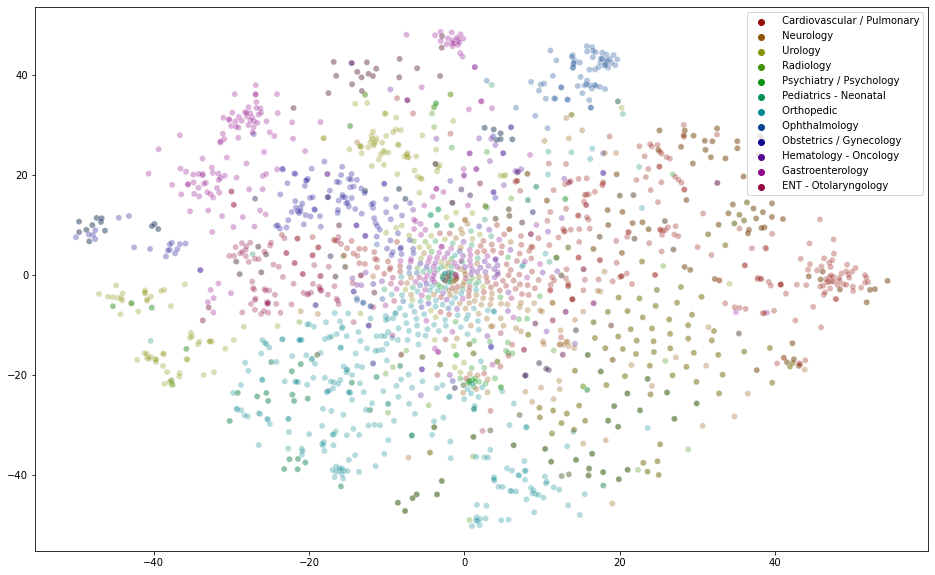

In [15]:
### t-SNE 
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense() 
labels = filtered_data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2, init = 'random', random_state=100, perplexity = 40).fit_transform(tfIdfMatrix)

plt.figure(figsize=(16,10))
palette = sns.hls_palette(12, l=.3, s = .9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue= labels,
    palette = palette,
    legend='full',
    alpha=0.3
)
plt.show()

## SMOTE for Imbalance Data (Oversampling)

In [17]:
## Solve the imbalance data
smote_over_sample = SMOTE(sampling_strategy = 'minority')
labels = filtered_data['medical_specialty'].tolist()
category_list = filtered_data.medical_specialty.unique()

## Reduce the dimensions
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())

X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=100)
print(X_train.shape, X_test.shape)

(1850, 547) (617, 547)


## Logistic Model for multi-class classification

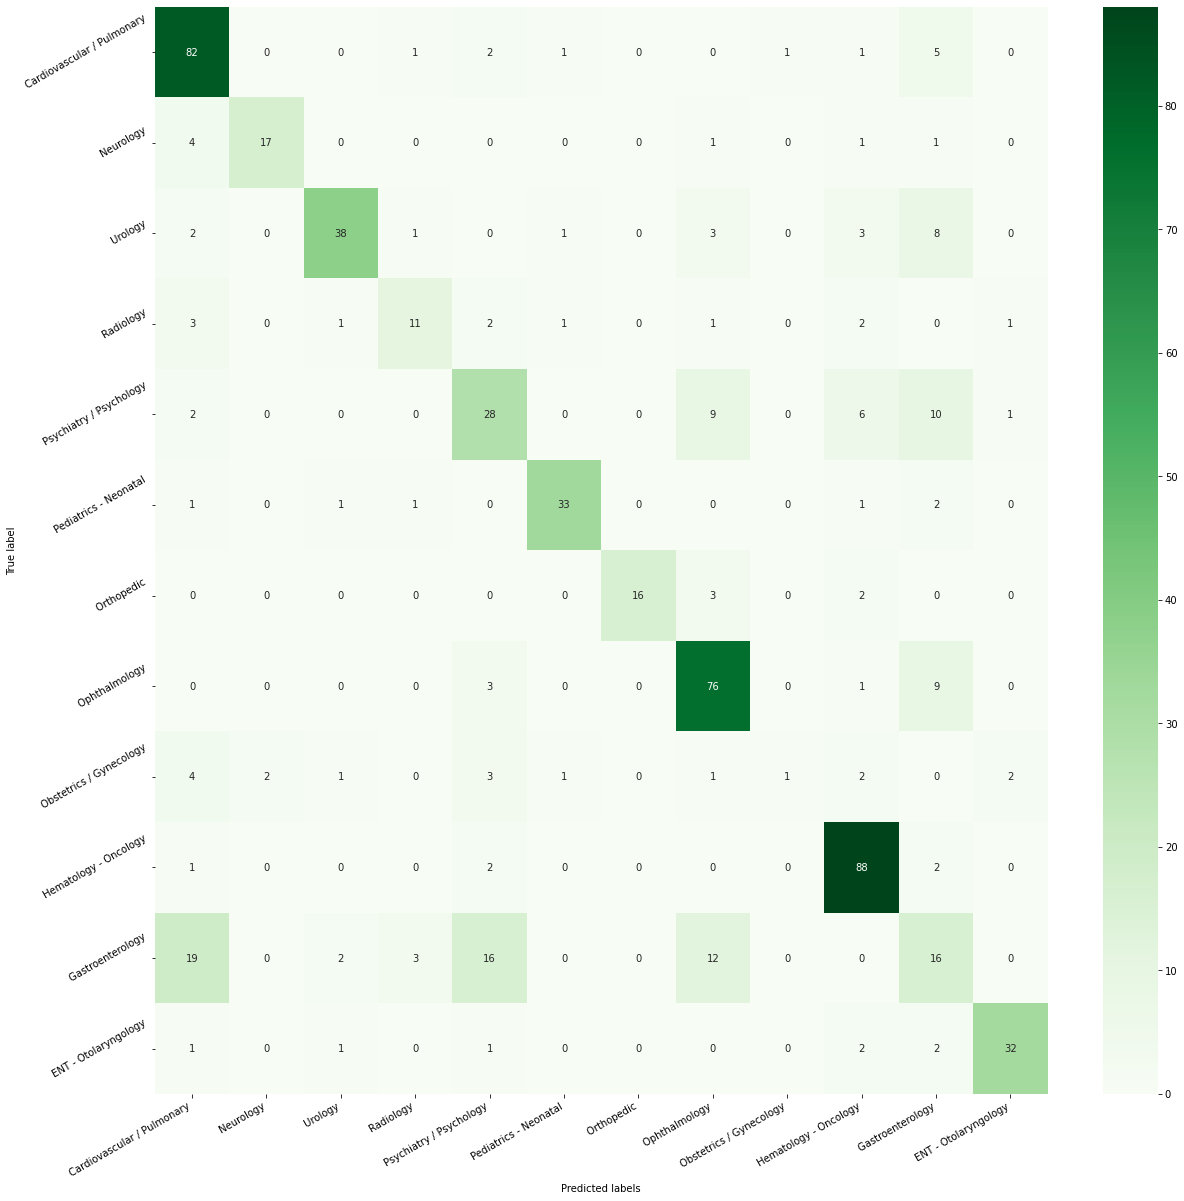

In [18]:
# Logistic model
clf = LogisticRegression(penalty= 'elasticnet', solver='saga', l1_ratio=0.5,random_state=100).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap='Greens', ax = ax, fmt='g')

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True label');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment = 'right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment = 'right')
plt.show()

In [21]:
## [Note]:We remove Surgery and serveral medical features which has correlation (overlapping) with other features (key words). 

In [22]:
print(classification_report(y_test,y_test_pred, labels=category_list))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.69      0.88      0.77        93
                  Neurology       0.49      0.50      0.50        56
                    Urology       0.89      0.82      0.85        39
                  Radiology       0.29      0.24      0.26        68
    Psychiatry / Psychology       0.81      0.95      0.87        93
      Pediatrics - Neonatal       0.50      0.06      0.11        17
                 Orthopedic       0.72      0.85      0.78        89
              Ophthalmology       1.00      0.76      0.86        21
    Obstetrics / Gynecology       0.89      0.85      0.87        39
      Hematology - Oncology       0.65      0.50      0.56        22
           Gastroenterology       0.86      0.68      0.76        56
       ENT - Otolaryngology       0.89      0.71      0.79        24

                   accuracy                           0.71       617
                  macro avg     

### Referencs:
1. Kaggle

   https://www.kaggle.com/tboyle10/medicaltranscriptions
   
2. Spacy

   https://allenai.github.io/scispacy/

   https://spacy.io/usage/v3-2

3. Youtube

   https://www.buymeacoffee.com/rithesh